In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
print()

print(diabetes_data.describe())
print("\n")

print('데이터 세트 Null 값 갯수 ',diabetes_data.isnull().sum().sum(), "\n")

Outcome
0    500
1    268
Name: count, dtype: int64

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760

In [2]:
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# # StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
# scaler = StandardScaler( )
# X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 개별 모델은 로지스틱 회귀와 KNN,  
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier(random_state=42)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt)], voting='soft')

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf, dt]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.6883
LogisticRegression 정확도: 0.7987
KNeighborsClassifier 정확도: 0.7208
DecisionTreeClassifier 정확도: 0.6623


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy), "\n")

# GridSearchCV
params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

# y_train = y_train.values.flatten()

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

랜덤 포레스트 정확도: 0.7727 

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 16}
최고 예측 정확도: 0.7638


In [6]:
rf_clf1 = RandomForestClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=30, n_jobs=-1)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

print(f"train 정확도: {rf_clf1.score(X_train, y_train)}")
print(f"test 정확도: {rf_clf1.score(X_test, y_test)}")

예측 정확도: 0.7403
train 정확도: 0.8110749185667753
test 정확도: 0.7402597402597403


#### GridSearchCV를 통한 평가와 직접 모델을 학습시켜 평가하는 것의 차이가 발생하는 이유
> - GridSearchCV는 교차 검증을 통해 하이퍼파라미터를 최적화하므로, 실제 테스트 데이터에 대한 성능보다 약간 높게 나올 수 있다.
> - 직접 모델을 학습시키는 경우, 과적합이 발생할 수 있어 실제 테스트 데이터에 대한 성능이 낮게 나올 수 있다.
> - 따라서 이 두 가지 방식은 서로 다른 목적으로 사용되며, 실제 모델의 성능을 평가할 때는 테스트 데이터에 대한 정확도가 더 중요
> - GridSearchCV를 통해 얻은 최적의 하이퍼파라미터를 사용하여 최종 모델을 학습시키고 테스트 데이터에 대한 성능을 측정하는 것이 일반적인 접근 방식

#### 과적합
> - max_depth 줄이기:
> - - max_depth를 줄이면 트리의 깊이가 낮아져 모델의 복잡도가 감소합니다.
> - - 이를 통해 과적합을 방지할 수 있습니다.

> - min_samples_leaf 늘리기:
> - - min_samples_leaf를 늘리면 리프 노드에 필요한 최소 샘플 수가 증가합니다.
> - - 이를 통해 모델이 과도하게 복잡해지는 것을 방지할 수 있습니다.

> - min_samples_split 늘리기:
> - - min_samples_split을 늘리면 노드를 분할하는 데 필요한 최소 샘플 수가 증가합니다.
> - - 이를 통해 과적합을 방지할 수 있습니다.

> - n_estimators 줄이기:
> - - n_estimators를 줄이면 의사결정 트리의 개수가 감소합니다.
> - - 이를 통해 전체 모델의 복잡도를 낮출 수 있습니다.

> - 정규화(regularization) 기법 사용하기:
> - - L1 또는 L2 정규화를 사용하여 모델의 복잡도를 제한할 수 있습니다.
> - - 이를 통해 과적합을 방지할 수 있습니다.

> - 더 많은 데이터 확보하기:
> - - 데이터 크기가 충분하지 않으면 과적합이 발생할 수 있습니다.
> - - 더 많은 데이터를 확보하면 모델의 일반화 성능을 높일 수 있습니다.

In [7]:
ftr_importances_values = rf_clf1.feature_importances_

ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)

ftr_importances.sort_values(ascending=False)[:20]

Glucose                     0.293819
Age                         0.208360
BMI                         0.185882
DiabetesPedigreeFunction    0.115276
Insulin                     0.069956
Pregnancies                 0.054276
SkinThickness               0.043668
BloodPressure               0.028764
dtype: float64

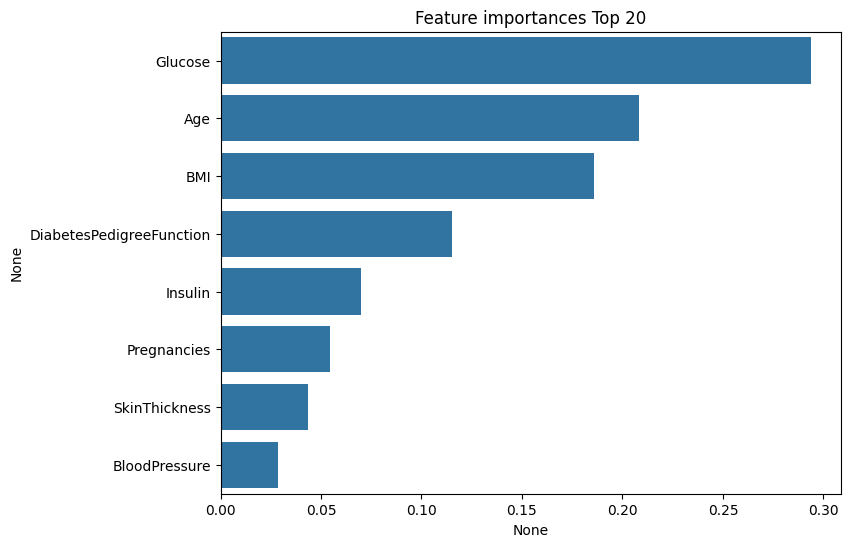

In [8]:
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [9]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    
    accuracy = accuracy_score(y_test , pred)
    
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    
    f1 = f1_score(y_test,pred)
    
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion, "\n")
    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc), "\n")


In [11]:
# VotingClassifier 학습/예측/평가. 
pred_vo = vo_clf.predict(X_test)
pred_proba_vo = vo_clf.predict_proba(X_test)[:, 1] # 분류 결정 예측 확률
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))
print(f"test 정확도: {vo_clf.score(X_test, y_test)}")

get_clf_eval(y_test , pred_vo, pred_proba_vo)
print("\n\n")


lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier(random_state=42)
rf_clf2 = RandomForestClassifier()
# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt), ('RF', rf_clf2)], voting='soft')

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred_vo2 = vo_clf.predict(X_test)
pred_proba_vo2 = vo_clf.predict_proba(X_test)[:, 1] # 분류 결정 예측 확률
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))
print(f"test 정확도: {vo_clf.score(X_test, y_test)}", "\n")

get_clf_eval(y_test , pred_vo2, pred_proba_vo2)

Voting 분류기 정확도: 0.7403
test 정확도: 0.7272727272727273
오차 행렬
[[75 20]
 [22 37]] 

정확도: 0.7273, 정밀도: 0.6491, 재현율: 0.6271,    F1: 0.6379, AUC:0.8030 




Voting 분류기 정확도: 0.7403
test 정확도: 0.7272727272727273 

오차 행렬
[[74 21]
 [21 38]] 

정확도: 0.7273, 정밀도: 0.6441, 재현율: 0.6441,    F1: 0.6441, AUC:0.8037 



#### 여러 개의 모델을 앙상블 학습으로 결합하는 것이 반드시 좋은 것은 아다. 
> - 앙상블 모델의 성능은 다음과 같은 요인들에 따라 달라질 수 있다:

> - 개별 모델의 성능: 앙상블에 포함된 개별 모델들의 성능이 좋지 않다면, 앙상블 모델의 성능도 제한적일 수 있다. 개별 모델들의 성능을 먼저 최적화하는 것이 중요.

> - 모델 간 다양성: 앙상블에 포함된 모델들이 서로 다른 방식으로 데이터를 학습하고 예측하는 경우에만 앙상블 모델의 성능이 향상될 수 있다.
> - 만약 모델들이 유사한 방식으로 동작한다면, 앙상블의 효과가 제한적일 수 있다.

> - 앙상블 방식의 적절성: 소프트 보팅 방식이 항상 가장 좋은 선택은 아니다. 문제에 따라 다른 앙상블 기법(하드 보팅, 스태킹 등)이 더 효과적일 수 있다.

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time), "\n\n")

print(f"GBM - train: {gb_clf.score(X_train, y_train)}")
print(f"GBM - test: {gb_clf.score(X_test, y_test)}")

GBM 정확도: 0.7727
GBM 수행 시간: 0.1 초  


GBM - train: 0.9348534201954397
GBM - test: 0.7727272727272727


In [13]:
### 아래는 강의에서 설명드리지는 않지만 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 아래는 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다. 
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 100}
최고 예측 정확도: 0.7443


In [14]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.7792
